Data Wrangling

In [1]:
# Imports
import glob
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import random

import kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Sequential

import shutil

import pandas as pd
from collections import Counter

2025-01-29 02:52:52.913217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Download

In [2]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


2. Data re-structuring

Right now, the data exists in a set of numbered directories, one for each patient. In each patient directory there are two sub-directories 0 and 1 containing IDC negative and IDC positive images. We need to collect all of the IDC negative images and IDC positive images into their own directories.

In [3]:
# Get a list of patient directories
patients=glob.glob(f'{path}/*')

# Set up target directories for file copy
idc_negative_directory='../data/idc_negative/'
idc_positive_directory='../data/idc_positive/'

Path(idc_negative_directory).mkdir(parents=True, exist_ok=True)
Path(idc_positive_directory).mkdir(parents=True, exist_ok=True)

# Loop on the patient directories and copy the '0' images to
# the idc_negative directory and the '1' images to the
# idc_positive directory
for patient in patients:

    # Copy the idc negative images from this patient
    idc_negative_images=glob.glob(f'{patient}/0/*.png')

    for image in idc_negative_images:
        shutil.copy(image, idc_negative_directory)

    # Copy the idc positive images from this patient
    idc_positive_images=glob.glob(f'{patient}/1/*.png')

    for image in idc_positive_images:
        shutil.copy(image, idc_positive_directory)

In [4]:
# Step 1b: Data Sampling for Efficiency
sampled_negative_directory = '../data_sampled/idc_negative/'
sampled_positive_directory = '../data_sampled/idc_positive/'

# Create directories for sampled data
Path(sampled_negative_directory).mkdir(parents=True, exist_ok=True)
Path(sampled_positive_directory).mkdir(parents=True, exist_ok=True)

# Sampling parameters
sample_size = 100  # Adjust as needed

In [5]:
# Function to sample and copy images
def sample_images(source_dir, target_dir, sample_size):
    images = glob.glob(f'{source_dir}/*.png')
    sampled_images = random.sample(images, min(sample_size, len(images)))
    for image in sampled_images:
        shutil.copy(image, target_dir)

In [6]:
# Sample negative and positive images
sample_images(idc_negative_directory, sampled_negative_directory, sample_size)
sample_images(idc_positive_directory, sampled_positive_directory, sample_size)

print("Sampling complete!")

Sampling complete!


EDA

In [7]:
idc_negative_count = len(glob.glob(f'{idc_negative_directory}/*.png'))
idc_positive_count = len(glob.glob(f'{idc_positive_directory}/*.png'))

print(f"IDC Negative Images: {idc_negative_count}")
print(f"IDC Positive Images: {idc_positive_count}")

IDC Negative Images: 198738
IDC Positive Images: 78786


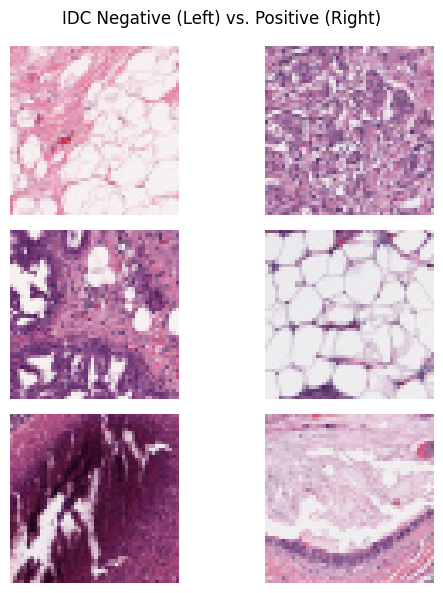

In [8]:
from tensorflow.keras.preprocessing import image

# Visualize IDC Negative and Positive Images Side-by-Side
negative_images = glob.glob(f'{idc_negative_directory}/*.png')[:3]
positive_images = glob.glob(f'{idc_positive_directory}/*.png')[:3]

fig, axs = plt.subplots(3, 2, figsize=(6, 6))  # Adjusted figsize for clarity
for neg_img, pos_img, row in zip(negative_images, positive_images, axs):
    for img_path, ax in zip([neg_img, pos_img], row):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        img /= 255.0  # Normalize image values
        ax.imshow(img)
        ax.axis('off')

plt.suptitle("IDC Negative (Left) vs. Positive (Right)")
plt.tight_layout()
plt.show()

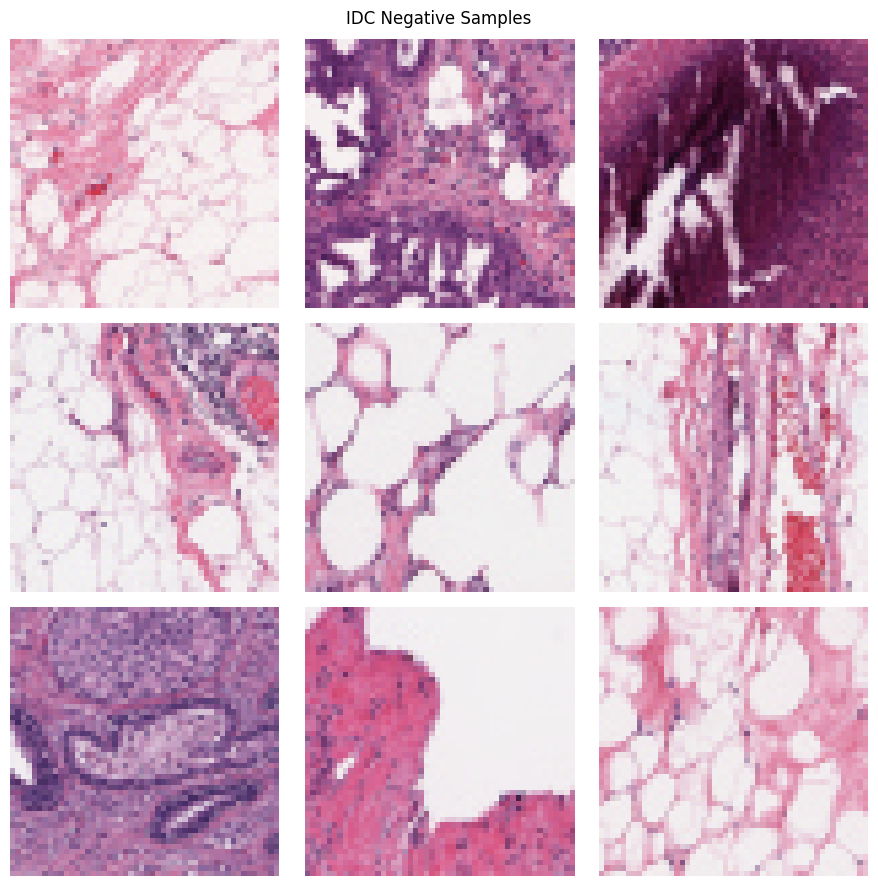

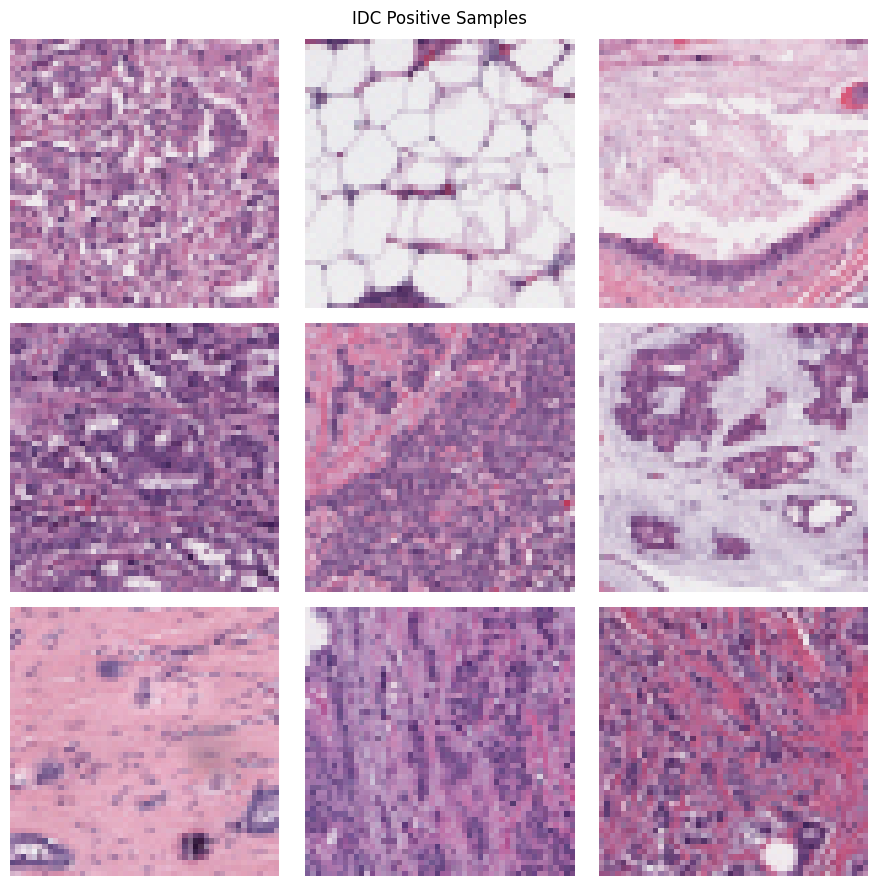

In [9]:
def plot_sample_images(directory, title, num_images=9):
    images = glob.glob(f"{directory}/*.png")
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flat[:min(num_images, len(images))]):
        img = plt.imread(images[i])
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_sample_images(idc_negative_directory, "IDC Negative Samples")
plot_sample_images(idc_positive_directory, "IDC Positive Samples")

In [10]:
data_summary = pd.DataFrame({
    "Class": ["IDC Negative", "IDC Positive"],
    "Image Count": [idc_negative_count, idc_positive_count]
})
print(data_summary)

          Class  Image Count
0  IDC Negative       198738
1  IDC Positive        78786


In [11]:
# Check for class imbalance
total_images = idc_negative_count + idc_positive_count
print(f"Class Distribution:\n{data_summary}")
print(f"IDC Negative: {idc_negative_count / total_images:.2%}, IDC Positive: {idc_positive_count / total_images:.2%}")
if abs(idc_negative_count - idc_positive_count) / total_images > 0.2:
    print("Warning: Potential class imbalance detected.")

Class Distribution:
          Class  Image Count
0  IDC Negative       198738
1  IDC Positive        78786
IDC Negative: 71.61%, IDC Positive: 28.39%


Prepare Image Dataset

In [12]:
def make_datasets(training_data_path: str, image_dim: int, batch_size: int=32):
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size,
        color_mode='grayscale'
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size,
        color_mode='grayscale'
    )
    return training_dataset, validation_dataset

image_dim = 50
batch_size = 128
training_dataset, validation_dataset = make_datasets('../data/', image_dim, batch_size)

Found 277524 files belonging to 2 classes.
Using 222020 files for training.
Found 277524 files belonging to 2 classes.
Using 55504 files for validation.


In [13]:
# training_dataset = training_dataset.take(100)
# validation_dataset = validation_dataset.take(50)

Sample Model

In [14]:
# def visualize_images(dataset, class_names):
#     images, labels = next(iter(dataset))
#     fig, axs = plt.subplots(3, 3, figsize=(9, 9))
#     for i, ax in enumerate(axs.flat[:images.shape[0]]):
#         ax.imshow(images[i].numpy().astype("uint8"))
#         ax.set_title(class_names[int(labels[i])])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# class_names = ['IDC Negative', 'IDC Positive']
# visualize_images(training_dataset, class_names)

define the model

In [15]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

Compile the model

In [16]:
from tensorflow import keras

# Define the optimizer
optimizer=keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Train the model

In [17]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    steps_per_epoch=100,
    validation_steps=100
) 

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 493ms/step - accuracy: 0.6733 - loss: 1.4203 - val_accuracy: 0.7216 - val_loss: 0.5841
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 811ms/step - accuracy: 0.7121 - loss: 0.6307 - val_accuracy: 0.7223 - val_loss: 0.5707
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.7168 - loss: 0.6063 - val_accuracy: 0.7215 - val_loss: 0.5503
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - accuracy: 0.7171 - loss: 0.6025 - val_accuracy: 0.7217 - val_loss: 0.5506
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 402ms/step - accuracy: 0.7212 - loss: 0.5947 - val_accuracy: 0.7223 - val_loss: 0.5159
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - accuracy: 0.7158 - loss: 0.5856 - val_accuracy: 0.7202 - val_loss: 0.5161
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 395ms/step - accuracy: 0.7220 - loss: 0.5833 - val_accuracy: 0.7216 - val_loss: 0.5012
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - accuracy: 0.7243 - loss: 0

/home/vscode/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.7190 - loss: 0.5690 - val_accuracy: 0.7223 - val_loss: 0.5321
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 374ms/step - accuracy: 0.7067 - loss: 0.5793 - val_accuracy: 0.7228 - val_loss: 0.5122
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - accuracy: 0.7090 - loss: 0.5792 - val_accuracy: 0.7221 - val_loss: 0.5087
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.7146 - loss: 0.5724 - val_accuracy: 0.7212 - val_loss: 0.5396
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 374ms/step - accuracy: 0.7225 - loss: 0.5709 - val_accuracy: 0.7216 - val_loss: 0.5166
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 365ms/step - accuracy: 0.7105 - loss: 0.5720 - val_accuracy: 0.7201 - val_loss: 0.5047
Epoch 24/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 403ms/step - accuracy: 0.7255 - loss: 0.5716 - val_accuracy: 0.7216 - val_loss: 0.5410
Epoch 25/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 357ms/step - accuracy: 0.7194 - loss: 0.567

Evaluate the model

In [18]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

434/434 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.7218 - loss: 0.5146
Validation Loss: 0.5160, Validation Accuracy: 0.7197


Training History

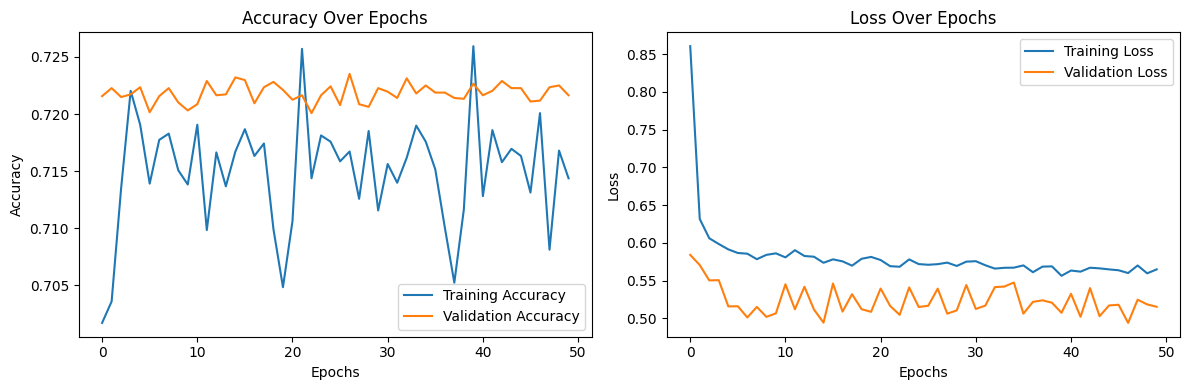

In [19]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [20]:
model.save('../data/model.keras')

In [21]:
import json

# Assume 'history' is the object returned by model.fit()
with open('../data/history.json', 'w') as f:
    json.dump(history.history, f)
